In [3]:
API_KEY = 'sk-proj-7MAfZbOm9lPY28pubTiRT3BlbkFJGgn73o5e6sVCjoTfoFAP'

Generating responses...
Generated 1000 responses.
Creating embeddings...
Embeddings created.
Data saved to generated_data.json
Data prepared for visualization and analysis.


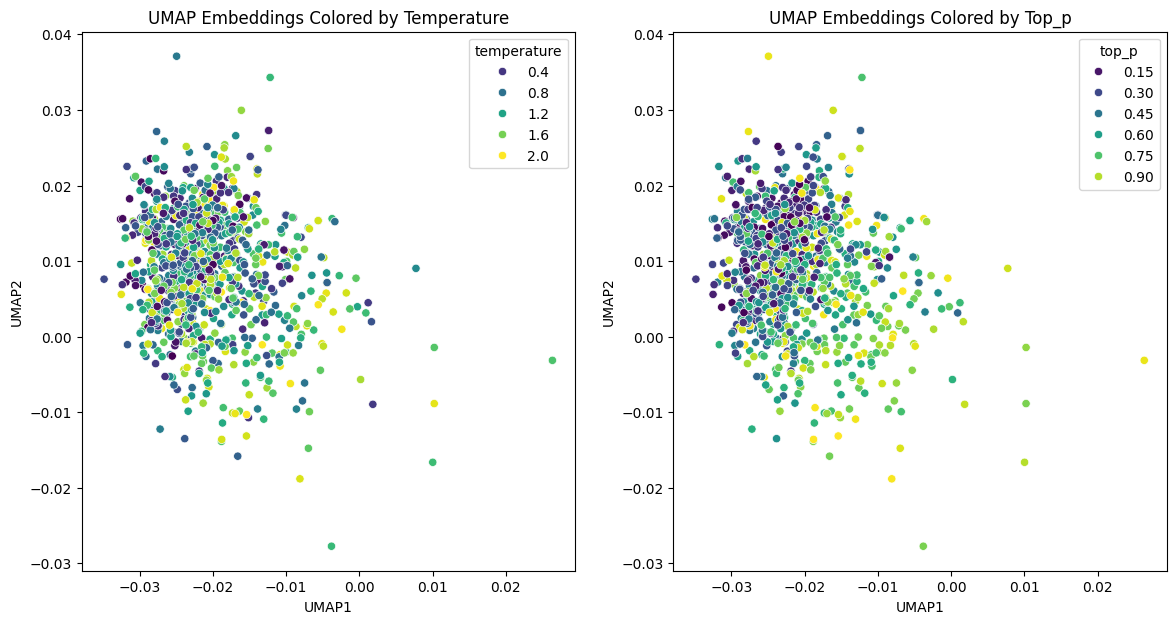

Visualization completed.
Correlation matrix:
                UMAP1     UMAP2  temperature     top_p  token_count  \
UMAP1        1.000000 -0.171510     0.180893  0.329202    -0.408609   
UMAP2       -0.171510  1.000000    -0.148305 -0.338926     0.015543   
temperature  0.180893 -0.148305     1.000000 -0.011241    -0.020358   
top_p        0.329202 -0.338926    -0.011241  1.000000    -0.037953   
token_count -0.408609  0.015543    -0.020358 -0.037953     1.000000   
max_tokens  -0.336531  0.050819    -0.009995 -0.020472     0.929003   

             max_tokens  
UMAP1         -0.336531  
UMAP2          0.050819  
temperature   -0.009995  
top_p         -0.020472  
token_count    0.929003  
max_tokens     1.000000  


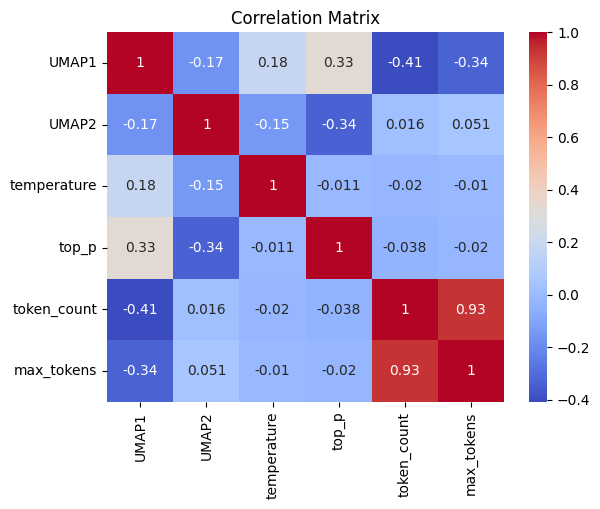

Regression results for UMAP1:
                            OLS Regression Results                            
Dep. Variable:                  UMAP1   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     110.0
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           1.24e-77
Time:                        19:51:26   Log-Likelihood:                 3759.2
No. Observations:                1000   AIC:                            -7508.
Df Residuals:                     995   BIC:                            -7484.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.02

In [4]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import random
import uuid
import statsmodels.api as sm
from openai import OpenAI

def generate_responses(api_key, input_text, model_config):
    client = OpenAI(api_key=api_key)
    responses = []
    for _ in range(model_config.get('n', 1)):
        max_tokens = random.choice(range(model_config.get('max_tokens_min', 100), model_config.get('max_tokens_max', 500) + 1, 10))
        temperature = round(random.uniform(model_config.get('temperature_min', 0.0), model_config.get('temperature_max', 2.0)), 2)
        top_p = round(random.uniform(model_config.get('top_p_min', 0.0), model_config.get('top_p_max', 1.0)), 2)

        response = client.chat.completions.create(
            model=model_config.get('name', "gpt-3.5-turbo"),
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": input_text}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
        )

        response_data = {
            'uuid': str(uuid.uuid4()),
            'response_content': response.choices[0].message.content,
            'configuration': {
                'max_tokens': max_tokens,
                'temperature': temperature,
                'top_p': top_p,
                'model': model_config.get('name', "gpt-3.5-turbo")
            }
        }
        responses.append(response_data)
    return responses

def extract_chat_completion_data(responses):
    response_data_list = []
    for response_data in responses:
        response_data_list.append({
            "uuid": response_data['uuid'],
            "response_content": response_data['response_content'],
            "configuration": response_data['configuration']
        })
    return response_data_list

def create_embeddings(api_key, data, embedding_models_config):
    client = OpenAI(api_key=api_key)
    embeddings = []
    for model_config in embedding_models_config:
        model_names = model_config['model'].split(',')
        for model_name in model_names:
            model_name = model_name.strip()
            for item in data:
                text = item['response_content'].replace("\n", " ")
                embedding = client.embeddings.create(input=[text], model=model_name).data[0].embedding
                embeddings.append({
                    "uuid": item['uuid'],
                    "embedding": embedding,
                    "embedding_model": model_name
                })
    return embeddings

def main():
    inference_config = {"name": "gpt-3.5-turbo", "n": 1000, "max_tokens_min": 50, "max_tokens_max": 500, "temperature_min": 0.1, "temperature_max": 2.0, "top_p_min": 0.1, "top_p_max": 1.0}
    test_input = "Imagine you are a time traveler visiting Earth in the year 3000. Describe the most surprising change you notice in one of the following areas and explain its impact on society: technology, environment, social norms, or political systems. Feel free to speculate on futuristic scenarios based on trends from your own time."

    print("Generating responses...")
    responses = generate_responses(API_KEY, test_input, inference_config)
    response_data_list = extract_chat_completion_data(responses)
    print(f"Generated {len(response_data_list)} responses.")

    embedding_config = [{'model': 'text-embedding-3-large'}]
    print("Creating embeddings...")
    all_embeddings = create_embeddings(API_KEY, response_data_list, embedding_config)
    print("Embeddings created.")

    # Combine response data with embeddings
    for item in response_data_list:
        item['embedding'] = next(embed['embedding'] for embed in all_embeddings if embed['uuid'] == item['uuid'])
        item['embedding_model'] = next(embed['embedding_model'] for embed in all_embeddings if embed['uuid'] == item['uuid'])

    # Save the data to a JSON file
    output_file = 'generated_data.json'
    with open(output_file, 'w') as f:
        json.dump(response_data_list, f, indent=4)

    print(f"Data saved to {output_file}")

    umap1, umap2 = [], []
    temperatures, top_ps, token_counts, max_tokens = [], [], [], []

    for item in response_data_list:
        embedding = item['embedding']
        umap1.append(embedding[0])
        umap2.append(embedding[1])
        response_config = item['configuration']
        temperatures.append(response_config['temperature'])
        top_ps.append(response_config['top_p'])
        max_tokens.append(response_config['max_tokens'])
        token_counts.append(len(item['response_content'].split()))

    data = pd.DataFrame({
        'UMAP1': umap1,
        'UMAP2': umap2,
        'temperature': temperatures,
        'top_p': top_ps,
        'token_count': token_counts,
        'max_tokens': max_tokens
    })

    print("Data prepared for visualization and analysis.")

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='UMAP1', y='UMAP2', hue='temperature', data=data, palette='viridis')
    plt.title('UMAP Embeddings Colored by Temperature')
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='UMAP1', y='UMAP2', hue='top_p', data=data, palette='viridis')
    plt.title('UMAP Embeddings Colored by Top_p')
    plt.show()

    print("Visualization completed.")

    correlation_matrix = data.corr()
    print("Correlation matrix:")
    print(correlation_matrix)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    X = data[['temperature', 'top_p', 'token_count', 'max_tokens']]
    X = sm.add_constant(X)
    y_umap1 = data['UMAP1']
    y_umap2 = data['UMAP2']

    model_umap1 = sm.OLS(y_umap1, X).fit()
    model_umap2 = sm.OLS(y_umap2, X).fit()

    print("Regression results for UMAP1:")
    print(model_umap1.summary())
    print("\nRegression results for UMAP2:")
    print(model_umap2.summary())

if __name__ == '__main__':
    main()


Generating responses...
Generated 1000 responses.
Creating embeddings...
Embeddings created.
Data saved to generated_data_4o.json
Data prepared for visualization and analysis.


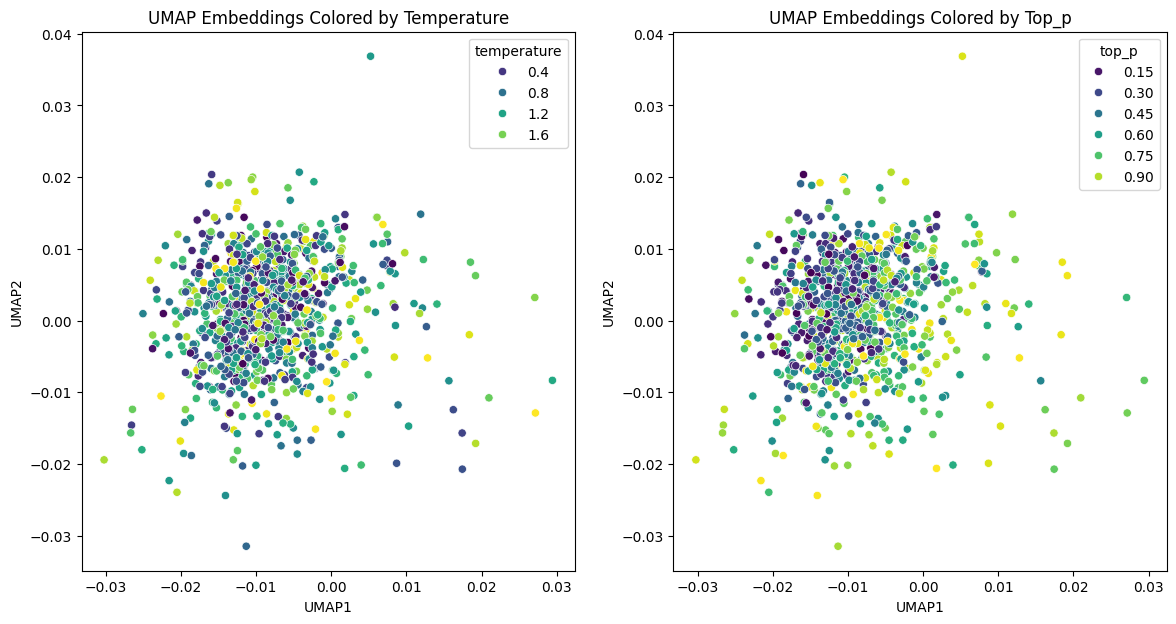

Visualization completed.
Correlation matrix:
                UMAP1     UMAP2  temperature     top_p  token_count  \
UMAP1        1.000000  0.082520     0.076457  0.275133    -0.356199   
UMAP2        0.082520  1.000000    -0.021473 -0.182848    -0.337620   
temperature  0.076457 -0.021473     1.000000  0.019039     0.016201   
top_p        0.275133 -0.182848     0.019039  1.000000     0.020911   
token_count -0.356199 -0.337620     0.016201  0.020911     1.000000   
max_tokens  -0.352291 -0.332094     0.015410  0.022481     0.996194   

             max_tokens  
UMAP1         -0.352291  
UMAP2         -0.332094  
temperature    0.015410  
top_p          0.022481  
token_count    0.996194  
max_tokens     1.000000  


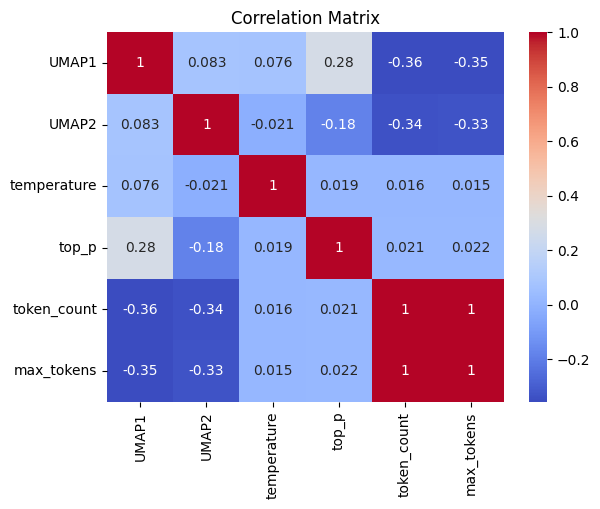

Regression results for UMAP1:
                            OLS Regression Results                            
Dep. Variable:                  UMAP1   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     67.44
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           1.57e-50
Time:                        22:23:44   Log-Likelihood:                 3617.4
No. Observations:                1000   AIC:                            -7225.
Df Residuals:                     995   BIC:                            -7200.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.00

In [5]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import random
import uuid
import statsmodels.api as sm
from openai import OpenAI

def generate_responses(api_key, input_text, model_config):
    client = OpenAI(api_key=api_key)
    responses = []
    for _ in range(model_config.get('n', 1)):
        max_tokens = random.choice(range(model_config.get('max_tokens_min', 100), model_config.get('max_tokens_max', 500) + 1, 10))
        temperature = round(random.uniform(model_config.get('temperature_min', 0.0), model_config.get('temperature_max', 2.0)), 2)
        top_p = round(random.uniform(model_config.get('top_p_min', 0.0), model_config.get('top_p_max', 1.0)), 2)

        response = client.chat.completions.create(
            model=model_config.get('name', "gpt-4o"),
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": input_text}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
        )

        response_data = {
            'uuid': str(uuid.uuid4()),
            'response_content': response.choices[0].message.content,
            'configuration': {
                'max_tokens': max_tokens,
                'temperature': temperature,
                'top_p': top_p,
                'model': model_config.get('name', "gpt-4o")
            }
        }
        responses.append(response_data)
    return responses

def extract_chat_completion_data(responses):
    response_data_list = []
    for response_data in responses:
        response_data_list.append({
            "uuid": response_data['uuid'],
            "response_content": response_data['response_content'],
            "configuration": response_data['configuration']
        })
    return response_data_list

def create_embeddings(api_key, data, embedding_models_config):
    client = OpenAI(api_key=api_key)
    embeddings = []
    for model_config in embedding_models_config:
        model_names = model_config['model'].split(',')
        for model_name in model_names:
            model_name = model_name.strip()
            for item in data:
                text = item['response_content'].replace("\n", " ")
                embedding = client.embeddings.create(input=[text], model=model_name).data[0].embedding
                embeddings.append({
                    "uuid": item['uuid'],
                    "embedding": embedding,
                    "embedding_model": model_name
                })
    return embeddings

def main():
    inference_config = {"name": "gpt-4o", "n": 1000, "max_tokens_min": 50, "max_tokens_max": 500, "temperature_min": 0.1, "temperature_max": 2.0, "top_p_min": 0.1, "top_p_max": 1.0}
    test_input = "Imagine you are a time traveler visiting Earth in the year 3000. Describe the most surprising change you notice in one of the following areas and explain its impact on society: technology, environment, social norms, or political systems. Feel free to speculate on futuristic scenarios based on trends from your own time."

    print("Generating responses...")
    responses = generate_responses(API_KEY, test_input, inference_config)
    response_data_list = extract_chat_completion_data(responses)
    print(f"Generated {len(response_data_list)} responses.")

    embedding_config = [{'model': 'text-embedding-3-large'}]
    print("Creating embeddings...")
    all_embeddings = create_embeddings(API_KEY, response_data_list, embedding_config)
    print("Embeddings created.")

    # Combine response data with embeddings
    for item in response_data_list:
        item['embedding'] = next(embed['embedding'] for embed in all_embeddings if embed['uuid'] == item['uuid'])
        item['embedding_model'] = next(embed['embedding_model'] for embed in all_embeddings if embed['uuid'] == item['uuid'])

    # Save the data to a JSON file
    output_file = 'generated_data_4o.json'
    with open(output_file, 'w') as f:
        json.dump(response_data_list, f, indent=4)

    print(f"Data saved to {output_file}")

    umap1, umap2 = [], []
    temperatures, top_ps, token_counts, max_tokens = [], [], [], []

    for item in response_data_list:
        embedding = item['embedding']
        umap1.append(embedding[0])
        umap2.append(embedding[1])
        response_config = item['configuration']
        temperatures.append(response_config['temperature'])
        top_ps.append(response_config['top_p'])
        max_tokens.append(response_config['max_tokens'])
        token_counts.append(len(item['response_content'].split()))

    data = pd.DataFrame({
        'UMAP1': umap1,
        'UMAP2': umap2,
        'temperature': temperatures,
        'top_p': top_ps,
        'token_count': token_counts,
        'max_tokens': max_tokens
    })

    print("Data prepared for visualization and analysis.")

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='UMAP1', y='UMAP2', hue='temperature', data=data, palette='viridis')
    plt.title('UMAP Embeddings Colored by Temperature')
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='UMAP1', y='UMAP2', hue='top_p', data=data, palette='viridis')
    plt.title('UMAP Embeddings Colored by Top_p')
    plt.show()

    print("Visualization completed.")

    correlation_matrix = data.corr()
    print("Correlation matrix:")
    print(correlation_matrix)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    X = data[['temperature', 'top_p', 'token_count', 'max_tokens']]
    X = sm.add_constant(X)
    y_umap1 = data['UMAP1']
    y_umap2 = data['UMAP2']

    model_umap1 = sm.OLS(y_umap1, X).fit()
    model_umap2 = sm.OLS(y_umap2, X).fit()

    print("Regression results for UMAP1:")
    print(model_umap1.summary())
    print("\nRegression results for UMAP2:")
    print(model_umap2.summary())

if __name__ == '__main__':
    main()
